In [1]:
import pyro
import torch
import random
pyro.set_rng_seed(101)

import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from memo import memo

In [2]:
label = {'interest': ["sports", "politics"],
         'connect_type': ["acquaintance", "close friend", "family"],
    }

In [3]:
class Person(object):
    def __init__(self):
        self.interest = self.getInterest()
    
    def getInterest(self):
        interest_prob = torch.tensor([0.5, 0.5])
        self.interest = pyro.sample("interest_ori", dist.Categorical(interest_prob))
        return self.interest

In [4]:
class Commenter(object):
    def __init__(self):
        self.interest = self.getInterest()
    
    def getInterest(self):
        interest_prob = torch.tensor([0.5, 0.5])
        self.interest = pyro.sample("c_interest", dist.Categorical(interest_prob))
        return self.interest

In [5]:
class Post(object):
    def __init__(self, poster):
        self.poster = poster
        self.topic = self.getTopic()
        
    def getTopic(self):
        prob_dict = {'poster': torch.tensor([0.9, 0.1]),
                    'other': torch.tensor([0.5, 0.5])}
        isPoster = pyro.sample("poster", dist.Categorical(prob_dict['poster']))
        if isPoster:
#             self.topic = pyro.sample('topic', dist.Delta(self.poster.interest))
            self.topic = self.poster.interest
        else:
            self.topic = pyro.sample("topic", dist.Categorical(prob_dict['other']))
        return self.topic

In [6]:
class Connection(object):
    def __init__(self, person1, person2):
        self.person1 = person1
        self.person2 = person2
        self.type = self.getType()
        
    def getType(self):
        self.type = random.choices(label['connect_type'], k=1)[0]
        return self.type

@memo
def generateConnection(person1, person2):
    return Connection(person1, person2)

In [7]:
class Comment(object):
    def __init__(self, post, commenter):
        self.post = post
        self.commenter = commenter
        self.isTopicMatch = post.topic == commenter.interest
        self.connectionType = generateConnection(post.poster, commenter).type
        self.constraint = self.getConstraint()
        
    def getConstraint(self):
        if self.isTopicMatch: 
            self.constraint = 1
        elif self.connectionType == "family":
            self.constraint = 0.8
        elif self.connectionType == "close friend":
            self.constraint = 0.5
        else:
            self.constraint = 0.1
        return self.constraint

In [8]:
def model():
    poster = Person()
    commenter = Commenter()
    post = Post(poster)
    comment = Comment(post, commenter)
    
    interest_prob = torch.tensor([0.5, 0.5])
    interest = pyro.sample("interest", dist.Categorical(interest_prob))
#     interest = pyro.sample('interest', poster.interest)
    topic = post.topic
    c_interest = commenter.interest
    match = torch.tensor(comment.constraint)
    
    return{'interest': interest,'topic': topic,'c_interest': c_interest,'match': match}

print(model())

{'interest': tensor(0), 'topic': tensor(0), 'c_interest': tensor(1), 'match': tensor(0.5000)}


([<matplotlib.axis.XTick at 0x20474ee6668>,
 <a list of 2 Text xticklabel objects>)

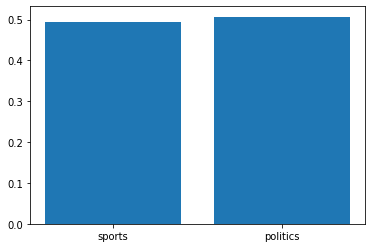

In [9]:
conditioned_model = pyro.condition(model, data={'topic': torch.tensor(1)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=1000).run()
marginal = EmpiricalMarginal(posterior, "interest")
samples = [marginal().item() for _ in range(1000)]
unique, counts = np.unique(samples, return_counts=True)

plt.bar(unique, counts/1000, align='center')
plt.xticks(unique, label['interest'])